## Modulation Recognition Example: 

This work is copyright DeepSig Inc. 2017.
It is provided open source under the Create Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) Licence
https://creativecommons.org/licenses/by-nc/4.0/

Use of this work, or derivitives inspired by this work is permitted for non-commercial usage only and with explicit citaiton of this original work.

A more detailed description of this work can be found at
https://arxiv.org/abs/1602.04105

A more detailed description of the RML2016.10a dataset can be found at
http://pubs.gnuradio.org/index.php/grcon/article/view/11

Citation of this work is required in derivative works:

```
@article{convnetmodrec,
  title={Convolutional Radio Modulation Recognition Networks},
  author={O'Shea, Timothy J and Corgan, Johnathan and Clancy, T. Charles},
  journal={arXiv preprint arXiv:1602.04105},
  year={2016}
}
@article{rml_datasets,
  title={Radio Machine Learning Dataset Generation with GNU Radio},
  author={O'Shea, Timothy J and West, Nathan},
  journal={Proceedings of the 6th GNU Radio Conference},
  year={2016}
}
```

The RML2016.10a dataset is used for this work (https://radioml.com/datasets/)


In [18]:
# python3 
# Import all the things we need ---
# by setting env variables before Keras import you can set up which backend and which GPU it uses
%matplotlib inline
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=gpu%d"%(1)
import numpy as np
#import theano as th
#import theano.tensor as T
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras
import pandas as pd


# Dataset setup

In [2]:
# Load the dataset ...
#  You will need to seperately download or generate this file
file_path = "./RML2016.10a/RML2016.10a_dict.pkl"
with open(file_path,'rb') as f:
    Xd = pickle.load(f,encoding='bytes')
    print(Xd)
    
    snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
    
    X = []  
    lbl = []
    for mod in mods:
        for snr in snrs:
            X.append(Xd[(mod,snr)])
            
            for i in range(Xd[(mod,snr)].shape[0]):  
                lbl.append((mod,snr))
    print(X)            
    X = np.vstack(X)

{(b'QPSK', 2): array([[[-0.00590147, -0.00234582, -0.00074506, ..., -0.00326824,
         -0.00304144,  0.00569031],
        [-0.00779554, -0.00781637, -0.00401967, ...,  0.01032196,
          0.00841506,  0.00544548]],

       [[ 0.00503262,  0.0009438 , -0.00189324, ...,  0.00710436,
          0.00647364,  0.00527375],
        [-0.00399943,  0.00161782,  0.00536932, ..., -0.00674945,
          0.00022403, -0.00185736]],

       [[ 0.00523907,  0.00738907,  0.00727646, ..., -0.00567421,
         -0.00974218, -0.01044694],
        [ 0.00419956,  0.0073807 ,  0.00528897, ..., -0.00246656,
          0.00416547, -0.00496793]],

       ...,

       [[ 0.0026172 ,  0.00298624,  0.00437732, ..., -0.00955281,
         -0.00808954, -0.00061479],
        [ 0.00322034,  0.00341152,  0.00447983, ...,  0.00353227,
          0.00287296,  0.00412169]],

       [[-0.00764636, -0.00967675, -0.00678905, ..., -0.00210244,
         -0.00629975, -0.00922944],
        [ 0.00805844,  0.00562819,  0.00702108

[array([[[-0.00716379, -0.00241632,  0.00063237, ..., -0.00422343,
          0.00362227,  0.00533994],
        [-0.00166505, -0.00144848, -0.01196972, ...,  0.00389698,
         -0.0052103 , -0.0007378 ]],

       [[ 0.00645143, -0.00212428, -0.00706135, ..., -0.00565343,
         -0.00104959, -0.00529411],
        [ 0.00329197, -0.00067204, -0.00282152, ...,  0.00315403,
         -0.00091081, -0.00107325]],

       [[ 0.00505826,  0.00445021, -0.00706326, ..., -0.00086023,
         -0.00832456, -0.00439183],
        [ 0.00454194,  0.00554406, -0.00336223, ...,  0.01007818,
          0.00437446,  0.00157776]],

       ...,

       [[-0.00151259, -0.00428863, -0.01558211, ...,  0.00094066,
          0.00665974,  0.00355963],
        [-0.00648331, -0.00097469,  0.00564184, ...,  0.00341373,
         -0.00462972, -0.00684248]],

       [[ 0.00229687, -0.00657757,  0.0016513 , ...,  0.00276324,
          0.00307279,  0.00016009],
        [ 0.00853982,  0.00065967, -0.00999137, ...,  0.0014

In [3]:
df = pd.DataFrame(X[0,:,:])
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.007164,-0.002416,0.000632,0.007660,-0.005539,-0.002563,-0.007037,-0.004982,0.015957,0.006146,...,0.001381,0.000932,-0.006268,0.002725,-0.004847,0.006247,0.000807,-0.004223,0.003622,0.005340
1,-0.001665,-0.001448,-0.011970,0.002786,-0.001433,-0.003465,-0.002055,-0.005515,0.001339,0.014432,...,0.002555,0.002107,0.002962,0.001484,0.002943,0.001738,-0.006822,0.003897,-0.005210,-0.000738


In [4]:
print(type(mods))
print(mods)

<class 'list'>
[b'8PSK', b'AM-DSB', b'AM-SSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16', b'QAM64', b'QPSK', b'WBFM']


In [5]:
print(type(snrs))
print(snrs)

<class 'list'>
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [6]:
print(lbl[:100])

[(b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK', -20), (b'8PSK

In [7]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
print(X.shape)

n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,n_examples), size=int(n_train), replace=False)

test_idx = list(set(range(0,n_examples))-set(train_idx))

X_train = X[train_idx]
X_test =  X[test_idx]
print(X_train.shape)

(220000, 2, 128)
(110000, 2, 128)


In [8]:
#python2 map return list
#python3 map return iteration
map(lambda x: x ** 2, [1, 2, 3, 4, 5]) 

In [9]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

In [10]:
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

In [11]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [12]:
Y_test.shape

(110000, 11)

In [13]:
Reshape([1]+in_shp, input_shape=in_shp)
[1]+in_shp

[1, 2, 128]

# Build the NN Model

In [117]:

# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.4 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(256, 1, 3, border_mode='valid', activation="relu", name="conv1", kernel_initializer='glorot_uniform'))
# model.add(Convolution2D(512, 1, 3, border_mode='valid', activation="relu", name="conv11", init='glorot_uniform'))
# model.add(Convolution2D(512, 1, 3, border_mode='valid', activation="relu", name="conv12", init='glorot_uniform'))
# model.add(Convolution2D(512, 1, 3, border_mode='valid', activation="relu", name="conv13", init='glorot_uniform'))
model.add(Dropout(dr))

# model.add(ZeroPadding2D((0, 2)))
# model.add(Convolution2D(128, 1, 3, border_mode="valid", activation="relu", name="conv2", kernel_initializer='glorot_uniform'))
# model.add(Dropout(dr))

model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(128, 1, 3, border_mode="valid", activation="relu", name="conv3", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1"))
model.add(Dropout(dr))
model.add(Dense( len(classes), kernel_initializer='he_normal', name="dense2" ))
model.add(Activation('softmax'))
#model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

c:\users\ezjinfe\work\mysklearn\venv\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (1, 3), activation="relu", name="conv1", kernel_initializer="glorot_uniform", padding="valid")`
  del sys.path[0]
c:\users\ezjinfe\work\mysklearn\venv\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 3), activation="relu", name="conv3", kernel_initializer="glorot_uniform", padding="valid")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_19 (Reshape)         (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_27 (ZeroPaddi (None, 3, 4, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 3, 2, 256)         98560     
_________________________________________________________________
dropout_35 (Dropout)         (None, 3, 2, 256)         0         
_________________________________________________________________
zero_padding2d_28 (ZeroPaddi (None, 5, 4, 256)         0         
_________________________________________________________________
conv3 (Conv2D)               (None, 5, 2, 128)         98432     
_________________________________________________________________
dropout_36 (Dropout)         (None, 5, 2, 128)         0         
__________

In [118]:
# Set up some params 
nb_epoch = 50     # number of epochs to train on
batch_size = 1024  # training batch size

# Train the Model

In [119]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
    ])


# we re-load the best weights once training is finished
model.load_weights(filepath)

Train on 110000 samples, validate on 110000 samples
Epoch 1/50
110000/110000 [==============================] - 42s 383us/step - loss: 2.2491 - acc: 0.1466 - val_loss: 2.1399 - val_acc: 0.1900

Epoch 00001: val_loss improved from inf to 2.13990, saving model to convmodrecnets_CNN2_0.5.wts.h5
Epoch 2/50
110000/110000 [==============================] - 48s 433us/step - loss: 2.0253 - acc: 0.2261 - val_loss: 1.8624 - val_acc: 0.3024

Epoch 00002: val_loss improved from 2.13990 to 1.86244, saving model to convmodrecnets_CNN2_0.5.wts.h5
Epoch 3/50
110000/110000 [==============================] - 44s 400us/step - loss: 1.8475 - acc: 0.2934 - val_loss: 1.7861 - val_acc: 0.3277

Epoch 00003: val_loss improved from 1.86244 to 1.78609, saving model to convmodrecnets_CNN2_0.5.wts.h5
Epoch 4/50
110000/110000 [==============================] - 43s 389us/step - loss: 1.7872 - acc: 0.3192 - val_loss: 1.7314 - val_acc: 0.3472

Epoch 00004: val_loss improved from 1.78609 to 1.73138, saving model to con

# Evaluate and Plot Model Performance

In [120]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test,  verbose=1, batch_size=batch_size)
print(score)

110000/110000 [==============================] - 9s 80us/step
[1.4730271686293863, 0.42009090908223934]


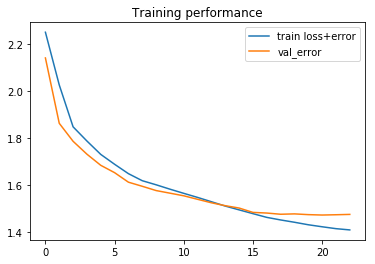

In [121]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [122]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

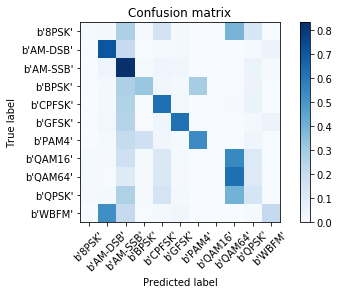

In [123]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])

for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
    
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

In [124]:
test_SNRs = map(lambda x: lbl[x][1], test_idx)
list(test_SNRs)

[-20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20,
 -20

Overall Accuracy:  0.09533394327538884
Overall Accuracy:  0.09227974568574024
Overall Accuracy:  0.09515195369030391
Overall Accuracy:  0.10483579935041501
Overall Accuracy:  0.12907930720145852
Overall Accuracy:  0.17735916118713346
Overall Accuracy:  0.3025904831894176
Overall Accuracy:  0.4534457478005865
Overall Accuracy:  0.5903881700554529
Overall Accuracy:  0.6396952104499274
Overall Accuracy:  0.6009124087591241
Overall Accuracy:  0.5777898945837877
Overall Accuracy:  0.5794787077826725
Overall Accuracy:  0.5732851985559567
Overall Accuracy:  0.5671776375112714
Overall Accuracy:  0.5615664845173042
Overall Accuracy:  0.5654535578489951
Overall Accuracy:  0.5694777634249861
Overall Accuracy:  0.5623529411764706
Overall Accuracy:  0.5720972097209721


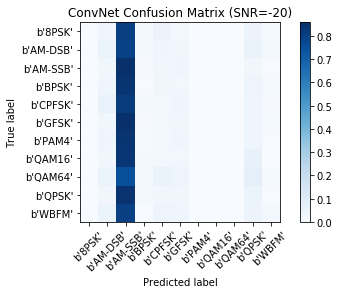

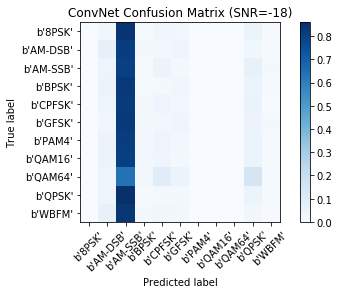

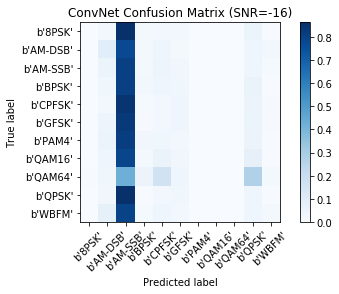

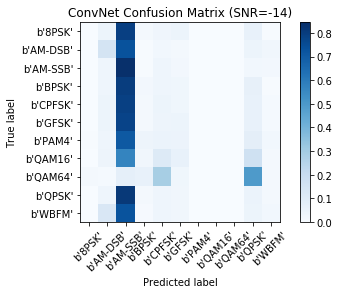

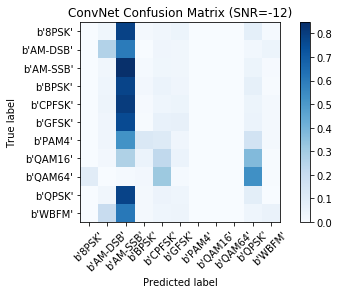

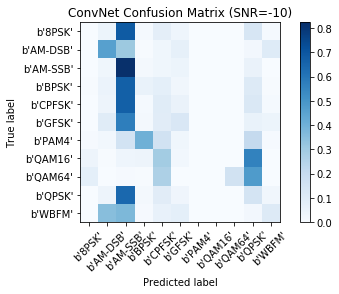

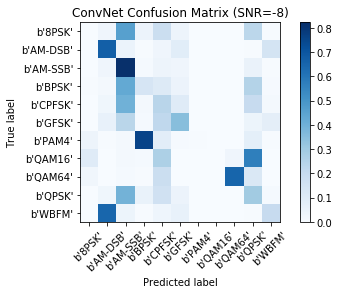

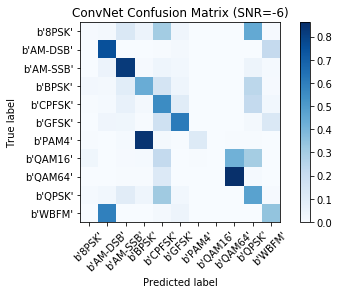

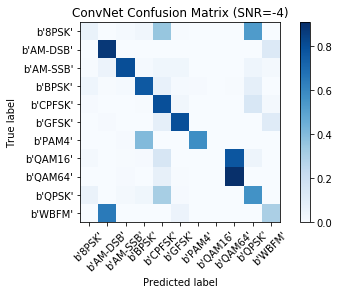

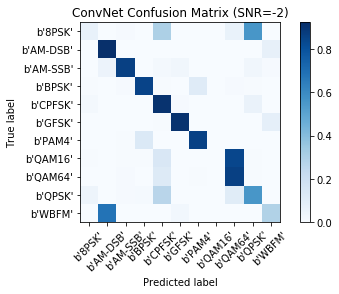

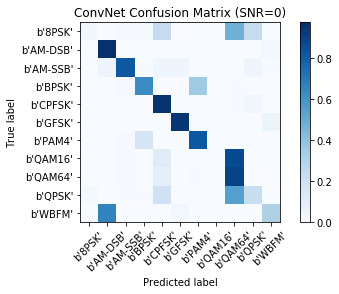

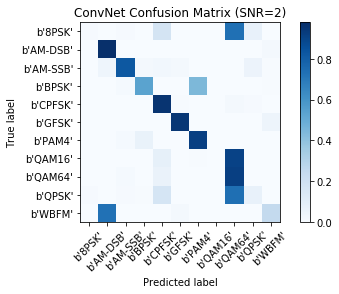

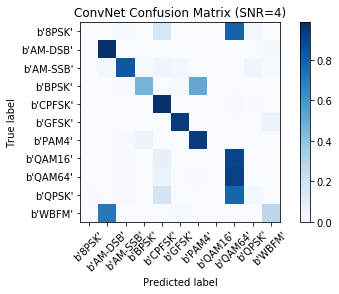

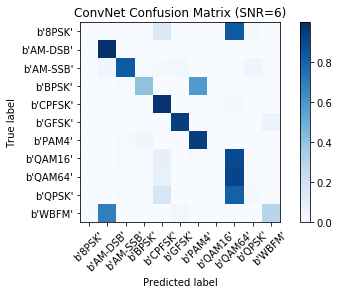

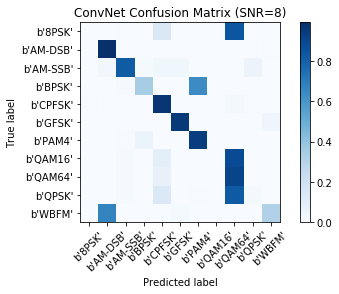

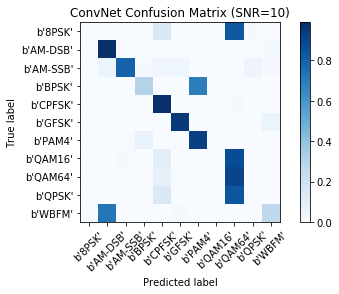

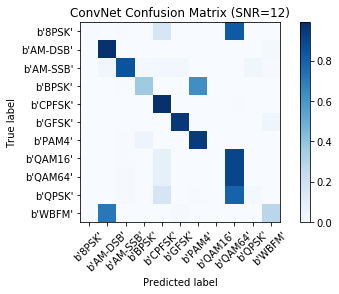

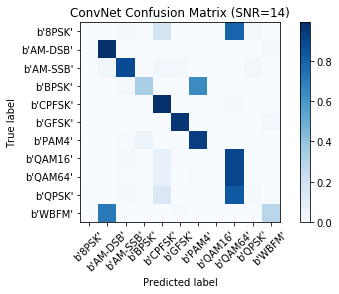

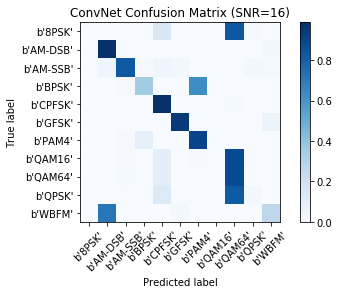

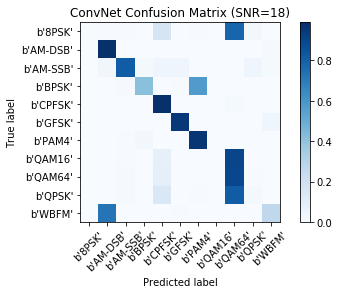

In [125]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    #print(snr)
    #print(np.array(list(test_SNRs)))
    #print(np.where(np.array(list(test_SNRs))==snr))
    
    mask = np.where(np.array(list(test_SNRs))==snr)
    #print("mask:{}".format(mask))
    test_X_i = X_test[mask]
    test_Y_i = Y_test[mask] 
    
#     print(test_X_i.shape)
#     print(test_Y_i.shape)

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    #print(test_Y_i_hat)
    
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    
    for i in range(0,test_X_i.shape[0]):
        # print( list(test_Y_i[i,:]))
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    #print(test_X_i)
    ncor = np.sum(conf) - cor
    acc[snr] = 1.0*cor/(cor+ncor)
    
    print("Overall Accuracy: ", acc[snr])
   

In [126]:
# Save results to a pickle file for plotting later
print(acc)
fd = open('results_cnn2_d0.5.dat','wb')
pickle.dump( ("CNN2", 0.5, acc) , fd )

{-20: 0.09533394327538884, -18: 0.09227974568574024, -16: 0.09515195369030391, -14: 0.10483579935041501, -12: 0.12907930720145852, -10: 0.17735916118713346, -8: 0.3025904831894176, -6: 0.4534457478005865, -4: 0.5903881700554529, -2: 0.6396952104499274, 0: 0.6009124087591241, 2: 0.5777898945837877, 4: 0.5794787077826725, 6: 0.5732851985559567, 8: 0.5671776375112714, 10: 0.5615664845173042, 12: 0.5654535578489951, 14: 0.5694777634249861, 16: 0.5623529411764706, 18: 0.5720972097209721}


Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

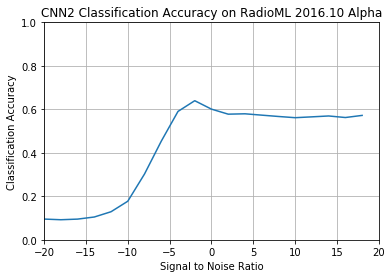

In [127]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlim([-20,20])
plt.ylim([0,1])
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.grid()
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")